In [1]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from qqdm.notebook import qqdm

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1, 4"

In [2]:
# You may replace the workspace directory if you want.
workspace_dir = './WGAN'
dataset_dir = '/data/dlcv/hw2/hw2_data'
os.makedirs(workspace_dir, exist_ok=True)
# Training progress bar
# !pip install -q qqdm

In [3]:
import random
import torch
import numpy as np

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# same_seeds(42)

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [4]:
class DCGANDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.12, contrast=0.12),
        # transforms.RandomRotation(degrees=5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = DCGANDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


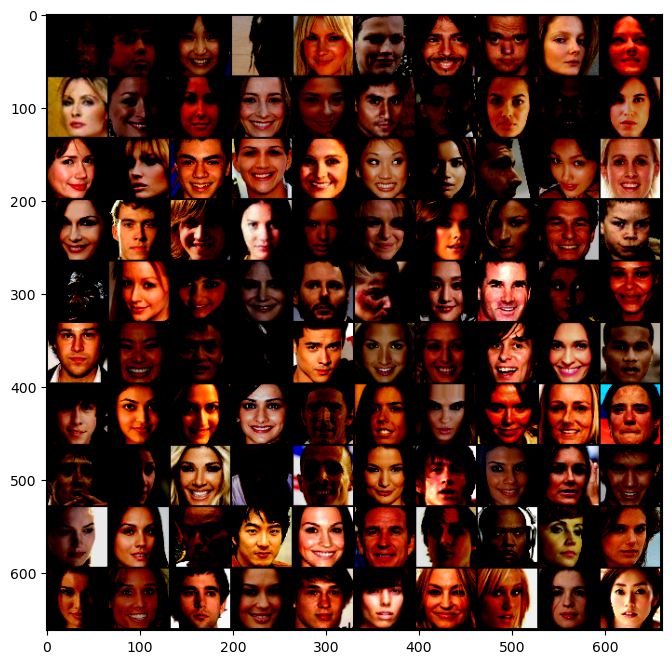

In [5]:
dataset = get_dataset(os.path.join(dataset_dir, 'face/train'))

images = [dataset[i] for i in range(100)]
grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

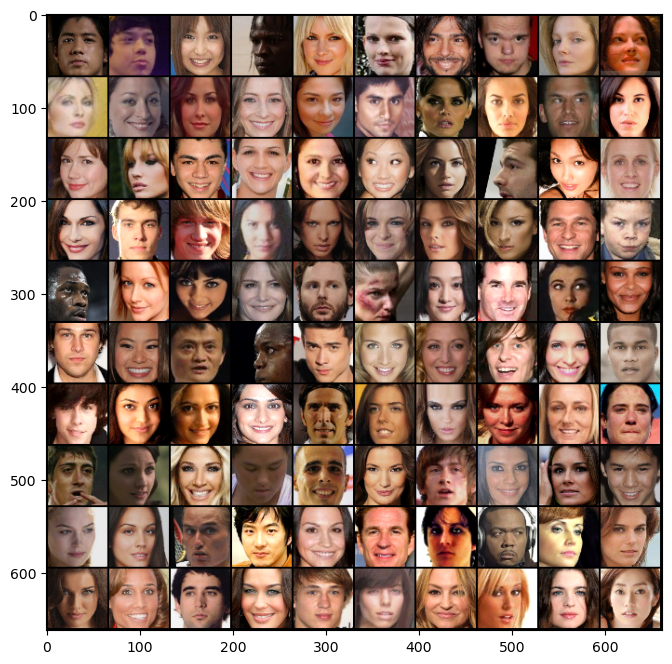

In [6]:
images = [(dataset[i]+1)/2 for i in range(100)]
grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

In [7]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.)

import torch
import torch.nn as nn
import torch.nn.init as init

def normalize_gradient(net_D, x, **kwargs):
    """
                     f
    f_hat = --------------------
            || grad_f || + | f |
    """
    x.requires_grad_(True)
    f = net_D(x, **kwargs)
    grad = torch.autograd.grad(
        f, [x], torch.ones_like(f), create_graph=True, retain_graph=True)[0]
    grad_norm = torch.norm(torch.flatten(grad, start_dim=1), p=2, dim=1)
    grad_norm = grad_norm.view(-1, *[1 for _ in range(len(f.shape) - 1)])
    f_hat = (f / (grad_norm + torch.abs(f)))
    return f_hat

def add_sn(model):
    for name, layer in model.named_children():
        model.add_module(name, add_sn(layer))
        if isinstance(model, (nn.Conv2d, nn.Linear)):
            return nn.utils.spectral_norm(model)
        else:
            return model
    return model

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(True)
            )
        self.l1 = nn.Sequential(
            # nn.Linear(in_dim, dim*8*4*4, bias=False),
            nn.ConvTranspose2d(in_dim, dim*16, kernel_size= 4, stride=1, bias=False),
            nn.BatchNorm2d(dim*16),
            nn.ReLU(True)
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim*16, dim*8),
            dconv_bn_relu(dim*8, dim*4),
            dconv_bn_relu(dim*4, dim*2),
            nn.ConvTranspose2d(dim*2, 3, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    def forward(self, x):
        y = self.l1(x)
        # y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y
    
class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        def conv_bn_lrelu(in_dim, out_dim, h, w):
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1, bias=False)),
                nn.LayerNorm([out_dim, h, w]),
                nn.LeakyReLU(0.2, inplace=True),
            )            
        self.ls = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_dim, dim, 4, 2, 1, bias=False)), 
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2, 16, 16),
            conv_bn_lrelu(dim * 2, dim * 4, 8, 8),
            conv_bn_lrelu(dim * 4, dim * 8, 4, 4),
            nn.utils.spectral_norm(nn.Conv2d(dim * 8, 1, kernel_size=4, bias=False)),
        )
        self.apply(weights_init)
        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y
    
def gradient_penalty(D, real_data, fake_data):
    LAMBDA = 10
    batch_size = real_data.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda()

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.cuda()
    
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = D(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [8]:
# Training hyperparameters
from random import seed

batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(64, z_dim, 1, 1)).cuda()
lr = 1e-4
nz = 100

n_epoch = 800 # 50
n_critic = 5 # 5
clip_value = 0.01

log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

tb_dir = os.path.join(workspace_dir, 'tb')
os.makedirs(tb_dir, exist_ok=True)

# Model
G = Generator(in_dim=z_dim, dim=64).cuda()
D = Discriminator(3).cuda()
print(G)
print(D)
G.train()
D.train()

# Loss
criterion = nn.BCELoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

sche_D = optim.lr_scheduler.ExponentialLR(opt_D, 0.99)
sche_G = optim.lr_scheduler.ExponentialLR(opt_G, 0.99)

# DataLoader
dataset = get_dataset(os.path.join(dataset_dir, 'face/train'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

same_seeds(7777)

# TensorBoard
writer = SummaryWriter(tb_dir)

Generator(
  (l1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1,

In [110]:
from torchsummary import summary   
summary(G, (100, 1, 1), 64)
summary(D, (3, 64, 64), 64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [64, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [64, 1024, 4, 4]           2,048
              ReLU-3           [64, 1024, 4, 4]               0
   ConvTranspose2d-4            [64, 512, 8, 8]      13,107,200
       BatchNorm2d-5            [64, 512, 8, 8]           1,024
              ReLU-6            [64, 512, 8, 8]               0
   ConvTranspose2d-7          [64, 256, 16, 16]       3,276,800
       BatchNorm2d-8          [64, 256, 16, 16]             512
              ReLU-9          [64, 256, 16, 16]               0
  ConvTranspose2d-10          [64, 128, 32, 32]         819,200
      BatchNorm2d-11          [64, 128, 32, 32]             256
             ReLU-12          [64, 128, 32, 32]               0
  ConvTranspose2d-13            [64, 3, 64, 64]           9,600
             Tanh-14            [64, 3,

### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

In [111]:
for e, epoch in enumerate(range(n_epoch)):
    # progress_bar = qqdm(dataloader)
    GerLoss = 0.
    DisLoss = 0.
    for i, data in enumerate(dataloader):
        
        imgs = data
        imgs = imgs.cuda()
        bs = imgs.size(0)
        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)
        # Model forwarding
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())      
        loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + 10.*gradient_penalty(D, r_imgs, f_imgs)
        DisLoss += loss_D.item()        
        # Model backwarding
        D.zero_grad()
        loss_D.backward()
        opt_D.step()        
        # ============================================
        #  Train G
        # ============================================
        if (i+1) % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()
            f_imgs = G(z)
            f_logit = D(f_imgs)     
            # WGAN Loss
            loss_G = -torch.mean(f_logit)
            GerLoss += loss_G.item()

            # Model backwarding
            G.zero_grad()
            loss_G.backward()
            # Update the generator.
            opt_G.step()
    n = len(dataloader.dataset)/bs
    print("epoch: {}; Loss_D: {}; Loss_G: {}, total D: {}, total G: {}".format(e+1, loss_D.item()/n, loss_G.item()/n, DisLoss/n, GerLoss/n))
    # sche_D.step()    
    # sche_G.step()
    
    if (e+1) % 5 == 0:
        f_imgs_sample = (G(z_sample).data + 1) / 2.0
        filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.png')
        torchvision.utils.save_image(f_imgs_sample, filename, nrow=8)
        print(f' | Save some samples to {filename}.')
    
    if (e+1) % 10 == 0 and e+1 >= 500:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, f'G_Epoch{epoch+1}.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, f'D_Epoch{epoch+1}.pth'))
        print(f' | Save some checkpoint for epoch{e+1}.')


epoch: 1; Loss_D: -0.16595367583974627; Loss_G: 0.10578702650530367, total D: -102.01976612919381, total G: 11.44501598504141
epoch: 2; Loss_D: -0.2260354751358413; Loss_G: 0.12350093187785982, total D: -124.14898974883576, total G: 13.918455241325493
epoch: 3; Loss_D: -0.20633609917715265; Loss_G: 0.1353118185592372, total D: -138.85619388523196, total G: 15.434786817198386
epoch: 4; Loss_D: -0.260142575484544; Loss_G: 0.14599090169947873, total D: -150.38500725211398, total G: 16.787764855510186
epoch: 5; Loss_D: -0.23189152417682768; Loss_G: 0.15319354522248077, total D: -164.22592168163737, total G: 18.08992451240933
 | Save some samples to ./WGAN/logs/Epoch_005.png.
epoch: 6; Loss_D: -0.28933682814612366; Loss_G: 0.1650694531331245, total D: -174.13184230379179, total G: 19.077659835434595
epoch: 7; Loss_D: -0.2960862653227693; Loss_G: 0.1673596678875052, total D: -180.3487039143948, total G: 19.893667973218463
epoch: 8; Loss_D: -0.3148867437327761; Loss_G: 0.17838207378165297, to

## Inference
Use the trained model to generate anime faces!

### Load model 

### Generate and show some images.


cuda


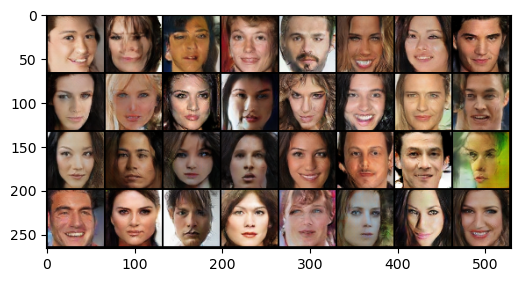

./WGAN/output


In [10]:
import torch

G = Generator(z_dim)
G.load_state_dict(torch.load('./GAN.pth'))
G.eval()
G.cuda()
# Generate 1000 images and make a grid to save them.
same_seeds(30)
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim, 1, 1)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.png')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=8)
torchvision.utils.save_image(grid_img, './report_sngan.png')
plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
# Save the generated images.
outputPath = os.path.join(workspace_dir, 'output')
print(outputPath)
os.makedirs(outputPath, exist_ok=True)
for i in range(1000):
    torchvision.utils.save_image(imgs_sample[i], f'WGAN/output/{i+1}.png')

In [11]:
!python -m pytorch_fid --device cuda:0 '/data/dlcv/hw2/hw2_data/face/val' './WGAN/output'
!python3 face_recog.py --image_dir "./WGAN/output"

/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.99it/s]
FID:  23.41066267938129
Start face recognition...
100%|██████████████████████████████████████| 1000/1000 [00:0